# Karachi Data KDE Estimation

Notebook to estimate the distribution of heat and humidity in the Karachi dataset from Cooley et al. (2019). We use a KDE where the kernels are beta distributed (bounded kernels). Specifically, we use first type of beta kernels defined in Songxi Chen's 1999 paper "Beta kernel estimators for density functions."

In [1]:
library(ggplot2)
library(dplyr)
library(caret)
library(gridExtra)

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘caret’ was built under R version 4.2.3”
Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.2.3”
Warning message:
“package ‘gridExtra’ was built under R version 4.2.3”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# functions to compute the bivariate KDE, assuming marginally independent kernels

dKarachiBetaKDE <- function(dat, point, b, lbs, ubs) {
    
    dat <- data.frame(X=(dat[,1]-lbs[1])/(ubs[1]-lbs[1]), 
                      Y=(dat[,2]-lbs[2])/(ubs[2]-lbs[2]))
    
    shape1sX <- dat[,1]/b + 1
    shape2sX <- (1-dat[,1])/b + 1
    
    shape1sY <- dat[,2]/b + 1
    shape2sY <- (1-dat[,2])/b + 1
    
    margXs <- dbeta((point[1]-lbs[1])/(ubs[1]-lbs[1]), 
                    shape1=shape1sX, shape2=shape2sX)*(1/(ubs[1]-lbs[1]))
    margYs <- dbeta((point[2]-lbs[2])/(ubs[2]-lbs[2]), 
                    shape1=shape1sY, shape2=shape2sY)*(1/(ubs[2]-lbs[2]))
    
    return(mean(margXs*margYs))
}

# just like dKarachiBetaKDE, except only takes the shapes so as to speed up the apply() method
# in the CV procedure
dKarachiBetaKDE2 <- function(shape1sX, shape2sX, shape1sY, shape2sY, point, lbs, ubs) {
    
    margXs <- dbeta((point[1]-lbs[1])/(ubs[1]-lbs[1]), 
                    shape1=shape1sX, shape2=shape2sX)*(1/(ubs[1]-lbs[1]))
    margYs <- dbeta((point[2]-lbs[2])/(ubs[2]-lbs[2]), 
                    shape1=shape1sY, shape2=shape2sY)*(1/(ubs[2]-lbs[2]))
    
    return(mean(margXs*margYs))
}

rKarachiBetaKDE <- function(n, b, dat, ubs, lbs) {
    
    kernel_inds <- sample(1:nrow(dat), n, replace=TRUE)
    dat <- dat[kernel_inds,]
    dat <- data.frame(X=(dat[,1]-lbs[1])/(ubs[1]-lbs[1]), 
                      Y=(dat[,2]-lbs[2])/(ubs[2]-lbs[2]))
    
    shape1sX <- dat[,1]/b + 1
    shape2sX <- (1-dat[,1])/b + 1
    
    shape1sY <- dat[,2]/b + 1
    shape2sY <- (1-dat[,2])/b + 1
    
    X <- rbeta(n, shape1=shape1sX, shape2=shape2sX)*(ubs[1]-lbs[1]) + lbs[1]
    Y <- rbeta(n, shape1=shape1sY, shape2=shape2sY)*(ubs[2]-lbs[2]) + lbs[2]
    
    draws <- data.frame(X=X, Y=Y)
    
    return(draws)
}

pKarachiBetaKDE <- function(dat, point, b, lbs, ubs) {

    dat <- data.frame(X=(dat[,1]-lbs[1])/(ubs[1]-lbs[1]), 
                      Y=(dat[,2]-lbs[2])/(ubs[2]-lbs[2]))
    
    shape1sX <- dat[,1]/b + 1
    shape2sX <- (1-dat[,1])/b + 1
    
    shape1sY <- dat[,2]/b + 1
    shape2sY <- (1-dat[,2])/b + 1
    
    margXs <- 1-(pbeta((point[1]-lbs[1])/(ubs[1]-lbs[1]), 
                    shape1=shape1sX, shape2=shape2sX))
    margYs <- 1-(pbeta((point[2]-lbs[2])/(ubs[2]-lbs[2]), 
                    shape1=shape1sY, shape2=shape2sY))
    
    return(mean(margXs*margYs))
    
}

In [4]:
load('~/isolines_uq/data/cooley_data/karachiDatDaily.Rdata')
karachiDat <- karachiDatDaily %>% select(relHum, temp)

To choose the bandwidth parameter for the KDE, we use a 5-fold CV, where we compute the log likelihood of some heldout set (assuming independence of observations) from a KDE constructed on the other 4 training folds. After running `runKarachiCV.R`, we obtain the following vector of log likelihoods and corresponding bandwidths.

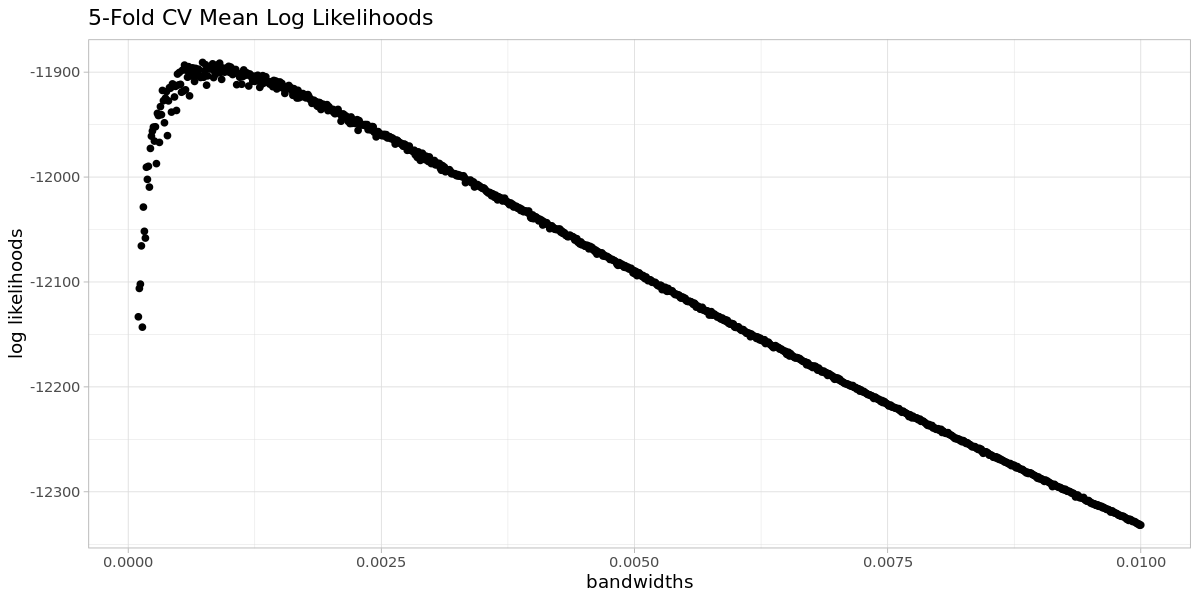

In [226]:
logliks <- readRDS('~/isolines_uq/results/karachiCVResults/karachiKDECV_lbw0.01_ubw1e-04_nbw1000.RData')
bws <- seq(0.01, 0.0001, length.out=1000)
plt_df <- data.frame(bws=bws, logliks=logliks)

ggplot(plt_df) + geom_point(aes(x=bws, y=logliks)) + ggtitle('5-Fold CV Mean Log Likelihoods') + 
xlab('bandwidths') + ylab('log likelihoods') + theme_light()

In [227]:
# grabbing the best bandwidth
best_bw <- bws[which.max(logliks)]
best_bw

[1] 0.0007342342

In [1]:
lower_bw <- 0.01
upper_bw <- 0.0001
n_bws <- 1000
bws <- seq(lower_bw, upper_bw, length.out=n_bws)


In [9]:
bws[bws == 0.000734234234234235]


numeric(0)

[1] 0.0100000000 0.0099900901 0.0099801802 0.0099702703 0.0099603604
   [6] 0.0099504505 0.0099405405 0.0099306306 0.0099207207 0.0099108108
  [11] 0.0099009009 0.0098909910 0.0098810811 0.0098711712 0.0098612613
  [16] 0.0098513514 0.0098414414 0.0098315315 0.0098216216 0.0098117117
  [21] 0.0098018018 0.0097918919 0.0097819820 0.0097720721 0.0097621622
  [26] 0.0097522523 0.0097423423 0.0097324324 0.0097225225 0.0097126126
  [31] 0.0097027027 0.0096927928 0.0096828829 0.0096729730 0.0096630631
  [36] 0.0096531532 0.0096432432 0.0096333333 0.0096234234 0.0096135135
  [41] 0.0096036036 0.0095936937 0.0095837838 0.0095738739 0.0095639640
  [46] 0.0095540541 0.0095441441 0.0095342342 0.0095243243 0.0095144144
  [51] 0.0095045045 0.0094945946 0.0094846847 0.0094747748 0.0094648649
  [56] 0.0094549550 0.0094450450 0.0094351351 0.0094252252 0.0094153153
  [61] 0.0094054054 0.0093954955 0.0093855856 0.0093756757 0.0093657658
  [66] 0.0093558559 0.0093459459 0.0093360360 0.0093261261 0.0093162162
  [71] 0.0093063063 0.0092963964 0.0092864865 0.0092765766 0.0092666667
  [76] 0.0092567568 0.0092468468 0.0092369369 0.0092270270 0.0092171171
  [81] 0.0092072072 0.0091972973 0.0091873874 0.0091774775 0.0091675676
  [86] 0.0091576577 0.0091477477 0.0091378378 0.0091279279 0.0091180180
  [91] 0.0091081081 0.0090981982 0.0090882883 0.0090783784 0.0090684685
  [96] 0.0090585586 0.0090486486 0.0090387387 0.0090288288 0.0090189189
 [101] 0.0090090090 0.0089990991 0.0089891892 0.0089792793 0.0089693694
 [106] 0.0089594595 0.0089495495 0.0089396396 0.0089297297 0.0089198198
 [111] 0.0089099099 0.0089000000 0.0088900901 0.0088801802 0.0088702703
 [116] 0.0088603604 0.0088504505 0.0088405405 0.0088306306 0.0088207207
 [121] 0.0088108108 0.0088009009 0.0087909910 0.0087810811 0.0087711712
 [126] 0.0087612613 0.0087513514 0.0087414414 0.0087315315 0.0087216216
 [131] 0.0087117117 0.0087018018 0.0086918919 0.0086819820 0.0086720721
 [136] 0.0086621622 0.0086522523 0.0086423423 0.0086324324 0.0086225225
 [141] 0.0086126126 0.0086027027 0.0085927928 0.0085828829 0.0085729730
 [146] 0.0085630631 0.0085531532 0.0085432432 0.0085333333 0.0085234234
 [151] 0.0085135135 0.0085036036 0.0084936937 0.0084837838 0.0084738739
 [156] 0.0084639640 0.0084540541 0.0084441441 0.0084342342 0.0084243243
 [161] 0.0084144144 0.0084045045 0.0083945946 0.0083846847 0.0083747748
 [166] 0.0083648649 0.0083549550 0.0083450450 0.0083351351 0.0083252252
 [171] 0.0083153153 0.0083054054 0.0082954955 0.0082855856 0.0082756757
 [176] 0.0082657658 0.0082558559 0.0082459459 0.0082360360 0.0082261261
 [181] 0.0082162162 0.0082063063 0.0081963964 0.0081864865 0.0081765766
 [186] 0.0081666667 0.0081567568 0.0081468468 0.0081369369 0.0081270270
 [191] 0.0081171171 0.0081072072 0.0080972973 0.0080873874 0.0080774775
 [196] 0.0080675676 0.0080576577 0.0080477477 0.0080378378 0.0080279279
 [201] 0.0080180180 0.0080081081 0.0079981982 0.0079882883 0.0079783784
 [206] 0.0079684685 0.0079585586 0.0079486486 0.0079387387 0.0079288288
 [211] 0.0079189189 0.0079090090 0.0078990991 0.0078891892 0.0078792793
 [216] 0.0078693694 0.0078594595 0.0078495495 0.0078396396 0.0078297297
 [221] 0.0078198198 0.0078099099 0.0078000000 0.0077900901 0.0077801802
 [226] 0.0077702703 0.0077603604 0.0077504505 0.0077405405 0.0077306306
 [231] 0.0077207207 0.0077108108 0.0077009009 0.0076909910 0.0076810811
 [236] 0.0076711712 0.0076612613 0.0076513514 0.0076414414 0.0076315315
 [241] 0.0076216216 0.0076117117 0.0076018018 0.0075918919 0.0075819820
 [246] 0.0075720721 0.0075621622 0.0075522523 0.0075423423 0.0075324324
 [251] 0.0075225225 0.0075126126 0.0075027027 0.0074927928 0.0074828829
 [256] 0.0074729730 0.0074630631 0.0074531532 0.0074432432 0.0074333333
 [261] 0.0074234234 0.0074135135 0.0074036036 0.0073936937 0.0073837838
 [266] 0.0073738739 0.0073639640 0.0073540541 0.0073441441 0.0073342342
 [271] 0.0073243243 0.0073144144 0.0073045045 0.0072945946 0.0072846847
 [276] 0.0072747748 0.0072648649 0.00725495

Now let's plot the distribution and some draws from the distribution too to see if it matches up well with reality..

In [228]:
mins <- c(0, 50)
maxs <- c(100, 140)
grid <- expand.grid(Humidity = seq(mins[1], maxs[1], length.out=100),
                   Temperature = seq(mins[2], maxs[2], length.out=100))

dens <- apply(grid, 1, dKarachiBetaKDE, dat=karachiDat, b=best_bw, lbs=mins, ubs=maxs)

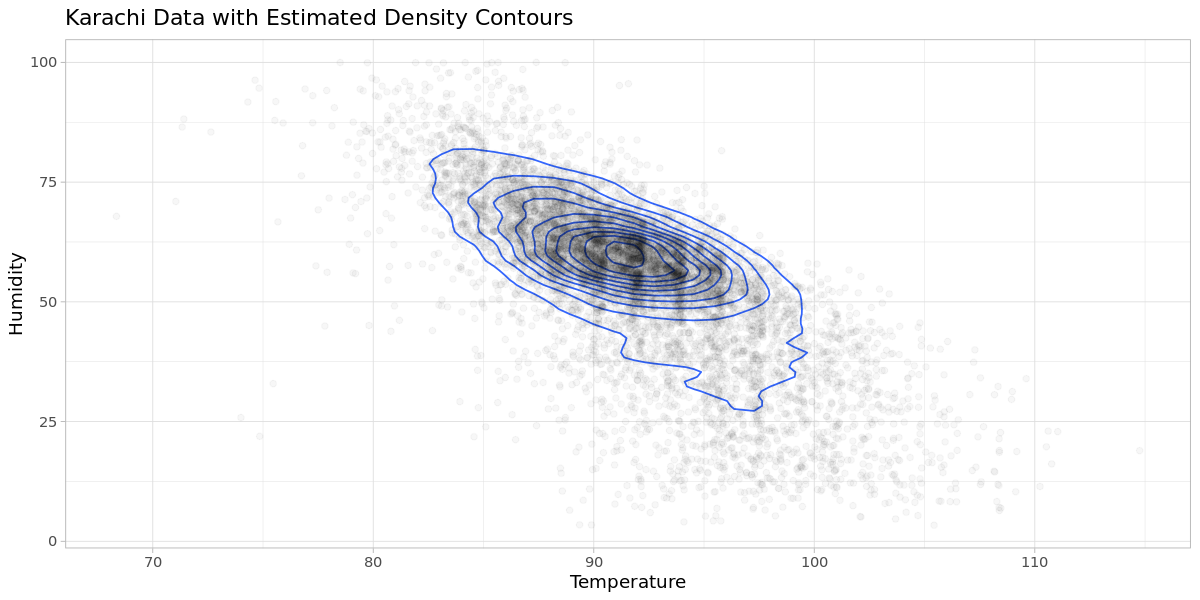

In [229]:
plt_df <- data.frame(Temperature = grid$Temperature, Humidity = grid$Humidity, density = dens)
ggplot() + geom_contour(data=plt_df,aes(x=Temperature, y=Humidity, z=density)) + 
geom_point(data=karachiDat, aes(x=temp, y=relHum), alpha=0.03) + ggtitle('Karachi Data with Estimated Density Contours') + theme_light()

In [230]:
pltKarachi <- ggplot() + geom_point(data=karachiDat, aes(x=temp, y=relHum), alpha=0.03) + 
xlab('Temperature (F)') + ylab('Relative Humidity') + ggtitle('Original Karachi Data') + theme_minimal()
karachiClone <- rKarachiBetaKDE(9000, best_bw, karachiDat, maxs, mins)
pltKarachiClone <- ggplot() + geom_point(data=karachiClone, aes(x=Y, y=X), alpha=0.03) +
xlab('Temperature (F)') + ylab('Relative Humidity') + ggtitle('Draw from Constructed Distribution') + theme_minimal()

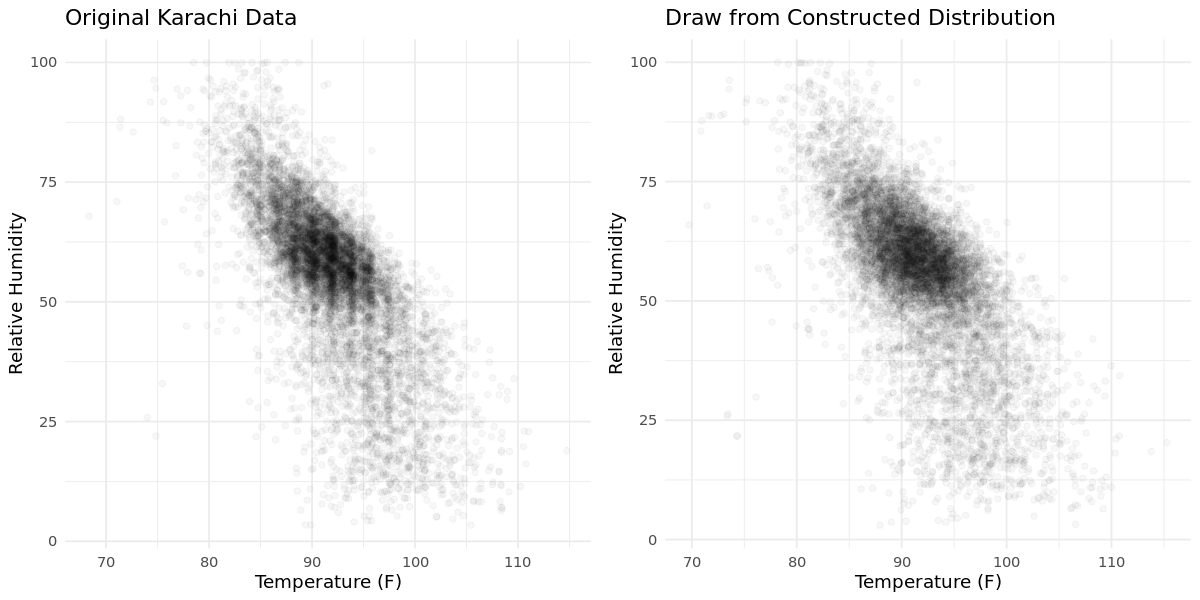

In [231]:
options(repr.plot.width=10, repr.plot.height=5)
grid.arrange(pltKarachi, pltKarachiClone, nrow = 1)

In [309]:
gsize <- 250

grid <- expand.grid(Humidity = seq(mins[1], maxs[1], length.out=gsize),
                   Temperature = seq(mins[2], maxs[2], length.out=gsize))
karachiSurvFunc <- apply(grid, 1, pKarachiBetaKDE, dat=karachiDat, b=best_bw, lbs=mins, ubs=maxs)

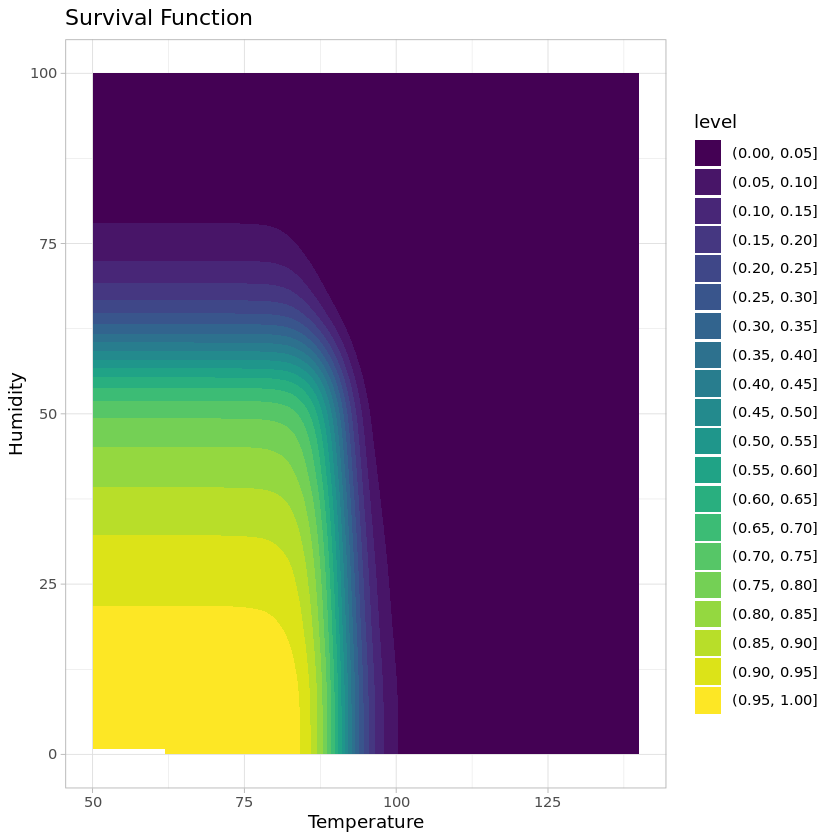

In [310]:
options(repr.plot.width=7, repr.plot.height=7)
plt_df <- data.frame(Temperature = grid$Temperature, Humidity = grid$Humidity, survfunc = karachiSurvFunc)
ggplot(plt_df) + geom_contour_filled(aes(x=Temperature, y=Humidity, z=survfunc), bins=20) + ggtitle('Survival Function') + theme_light()

In [311]:
contours <- contourLines(x=seq(mins[1], maxs[1], length.out=gsize), 
                         y=seq(mins[2], maxs[2], length.out=gsize),
                         z=matrix(karachiSurvFunc, ncol=gsize),
                        levels=c(0.05, 0.01, 0.001, 0.0001))

iso1 <- data.frame(X=contours[[1]]$y, Y=contours[[1]]$x)
iso2 <- data.frame(X=contours[[2]]$y, Y=contours[[2]]$x)
iso3 <- data.frame(X=contours[[3]]$y, Y=contours[[3]]$x)
iso4 <- data.frame(X=contours[[4]]$y, Y=contours[[4]]$x)

plt_df <- rbind(iso1, iso2, iso3, iso4)
plt_df <- cbind(plt_df, p=c(rep('0.05', nrow(iso1)), rep('0.01', nrow(iso2)), rep('0.001', nrow(iso3)), rep('0.0001', nrow(iso4))))

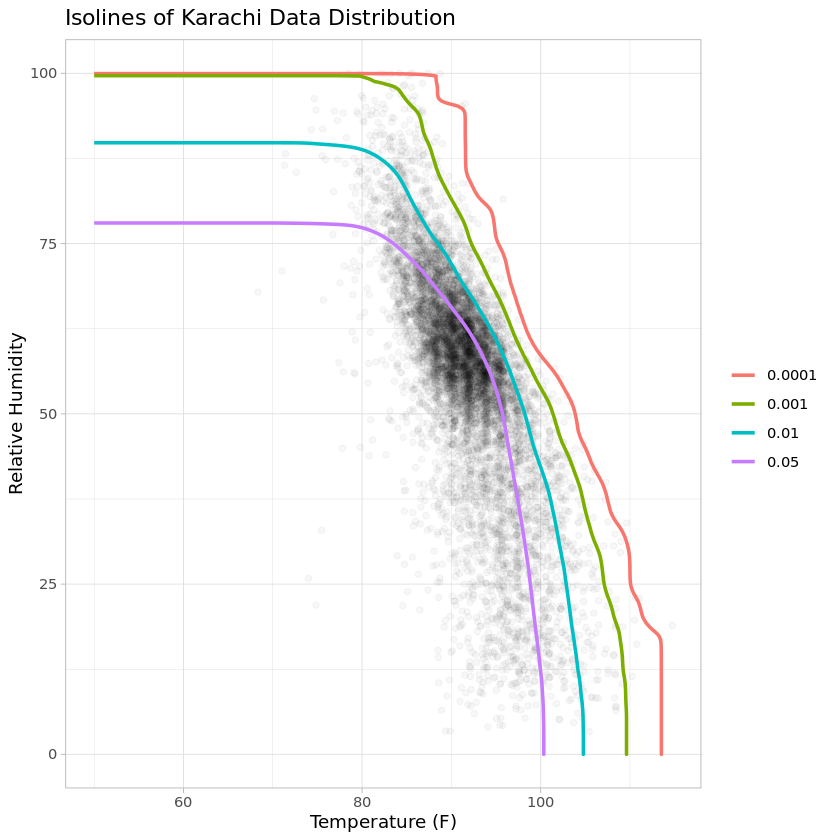

In [319]:
options(repr.plot.width=7, repr.plot.height=7)

iso_df <- plt_df[p-tol <= karachiSurvFunc & karachiSurvFunc <= p+tol,]
ggplot() + geom_point(data=karachiDat, aes(x=temp, y=relHum), alpha = 0.03) + 
xlab('Temperature (F)') + ylab('Relative Humidity') + 
geom_line(data=plt_df, aes(x=X, y=Y, color=as.factor(p)), size=1) + theme_light() + ggtitle('Isolines of Karachi Data Distribution')+ 
theme(legend.title=element_blank())


